In [1]:
!pip install pandas matplotlib seaborn altair pingouin

In [2]:
import pathlib as plib
from tabulate import tabulate

import pandas as pd

import scipy.stats as st
import pingouin as pg # for post-host pairwise test
from statsmodels.stats.anova import AnovaRM # for anova test

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
cwd = plib.Path.cwd()

if cwd.name == 'favorite_letters':
    print("Path is project root")
else:
    print('Current Working Directory is:', cwd)
    print("Recomend navigating to the project root in terminal and opening your chosen idea via the command 'code .'")
    raise NameError('Please correct current working directory to the project root')

data_path = plib.PurePath('letter_popularity_poll-Responses-sorted_data.csv')

Path is project root


In [4]:
data = pd.read_csv(data_path)
data.tail(3)

,letter,codepoint,block,name,0,1,2,3,4,5,6,average,standard dev.,ratings,tier
1173,Ṹ,7800,Latin Extended Additional,Ṹ (LATIN CAPITAL LETTER U WITH TILDE AND ACUTE),19,22,12,9,2,2,1,1.44776,1.39570,67,D
1174,ấ,7845,Latin Extended Additional,ấ (LATIN SMALL LETTER A WITH CIRCUMFLEX AND AC...,22,22,12,8,1,1,3,1.40580,1.50801,69,D
1175,Ễ,7876,Latin Extended Additional,Ễ (LATIN CAPITAL LETTER E WITH CIRCUMFLEX AND ...,24,22,15,6,3,1,2,1.35616,1.42760,73,D


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   letter         1176 non-null   object 
 1   codepoint      1176 non-null   int64  
 2   block          1176 non-null   object 
 3   name           1176 non-null   object 
 4   0              1176 non-null   int64  
 5   1              1176 non-null   int64  
 6   2              1176 non-null   int64  
 7   3              1176 non-null   int64  
 8   4              1176 non-null   int64  
 9   5              1176 non-null   int64  
 10  6              1176 non-null   int64  
 11  average        1176 non-null   float64
 12  standard dev.  1176 non-null   float64
 13  ratings        1176 non-null   int64  
 14  tier           1176 non-null   object 
dtypes: float64(2), int64(9), object(4)
memory usage: 137.9+ KB


# TODO: describe describe

In [6]:
describe_df = data.describe()
describe_df

,codepoint,0,1,2,3,4,5,6,average,standard dev.,ratings
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,15330.961735,7.880952,12.798469,13.196429,14.121599,11.479592,7.392007,7.800170,2.778416,1.658098,74.669218
std,25235.732055,4.697608,5.967232,4.712466,4.904155,5.966824,5.512098,6.682084,0.711294,0.173744,9.312829
min,65.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.356160,1.220240,42.000000
25%,440.750000,4.000000,8.000000,10.000000,11.000000,7.000000,3.000000,3.000000,2.219498,1.533622,69.750000
50%,7552.500000,7.000000,13.000000,13.000000,13.000000,11.000000,6.000000,6.000000,2.684210,1.647065,75.000000
75%,11371.250000,10.250000,17.000000,16.000000,17.000000,16.000000,11.000000,10.000000,3.329030,1.765290,80.000000
max,122666.000000,29.000000,29.000000,27.000000,37.000000,30.000000,28.000000,53.000000,4.724140,2.364680,107.000000


In [7]:
plot_describe_df = describe_df.transpose().loc['0':'6'].reset_index()
plot_describe_df = plot_describe_df.rename(columns={'index':'rating'})
plot_describe_df['lower_bound']  = plot_describe_df['mean'] - plot_describe_df['std']
plot_describe_df['upper_bound']  = plot_describe_df['mean'] + plot_describe_df['std']
plot_describe_df

,rating,count,mean,std,min,25%,50%,75%,max,lower_bound,upper_bound
0,0,1176.0,7.880952,4.697608,0.0,4.0,7.0,10.25,29.0,3.183345,12.578560
1,1,1176.0,12.798469,5.967232,0.0,8.0,13.0,17.00,29.0,6.831237,18.765702
2,2,1176.0,13.196429,4.712466,1.0,10.0,13.0,16.00,27.0,8.483962,17.908895
3,3,1176.0,14.121599,4.904155,3.0,11.0,13.0,17.00,37.0,9.217444,19.025753
4,4,1176.0,11.479592,5.966824,0.0,7.0,11.0,16.00,30.0,5.512768,17.446416
5,5,1176.0,7.392007,5.512098,0.0,3.0,6.0,11.00,28.0,1.879909,12.904105
6,6,1176.0,7.800170,6.682084,1.0,3.0,6.0,10.00,53.0,1.118086,14.482254


# Distributions of average ratings and assigned Tier


## Skew and Kurtosis
Skew of averages is 0.376, fairly low. This distribution of averages is not considerably skewed, as can be seen in the plot, the median and mode are close together. Difference of 0.094, ~ 3% on observed scale.

Negative kurtosis (-1) indicates our distributionof averages is considerably flatter than a normal distribution. This is not concerning as a distributions of averages is expected to be flatter than normal.

In [8]:
tier_full = ['S+', 'S', 'S-', 'A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']
data['tier'].unique()

array(['A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D'],
      dtype=object)

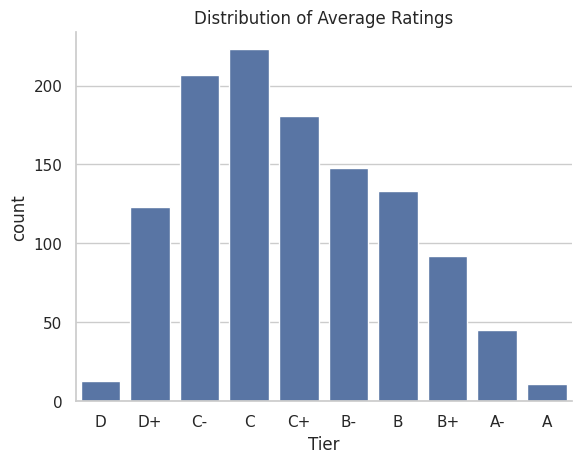

In [9]:
fig, ax = plt.subplots()
sns.countplot(data=data, x='tier')

ax.xaxis.set_inverted(True)
ax.set_xlabel("Tier")
ax.set_title("Distribution of Average Ratings")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/tier_dist_freq_plot")

In [10]:
mean = round(data['average'].mean(), 3)
median = round(data['average'].median(), 3)

print('mean', mean, '| median', median)

print('mode')
data['average'].\
    value_counts().\
        sort_values(ascending=False).\
            rename('freq').\
                head(3)\
                    .reset_index()

mean 2.778 | median 2.684
mode


,average,freq
0,3.50000,6
1,2.00000,6
2,1.85714,4


16 potential tiers, only 10 applicable to data


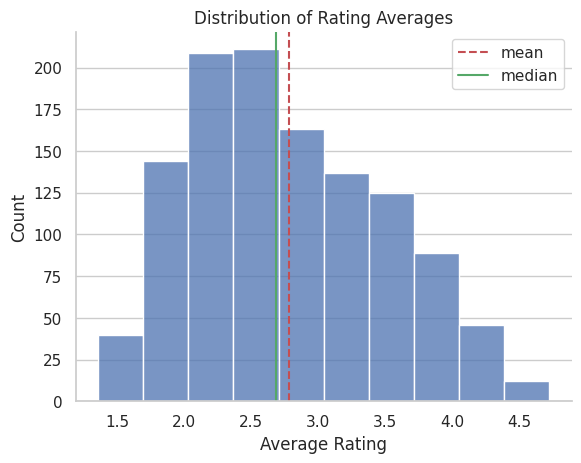

In [11]:
print(f'{len(tier_full)} potential tiers, only 10 applicable to data')

fig, ax = plt.subplots()
sns.histplot(data=data, x='average', bins=10)

# add median line
ax.axvline(mean, color='r', linestyle='--', label='mean')
# add mean line
ax.axvline(median, color='g', linestyle='-',label='median')
# add legend
ax.legend()

ax.set_xlabel("Average Rating")
ax.set_title("Distribution of Rating Averages")
ax.grid(False, axis='x')
sns.despine()
fig.savefig("images/rating_dist_histogram")

In [12]:
print('Diff of Median and mean:', round(median - mean, 3))

Diff of Median and mean: -0.094


In [13]:
skew_avgs = round(st.skew(data['average']), 3)
kurtosis_avgs = round(st.kurtosis(data['average']))
print('skew:', skew_avgs, '| kurtosis', kurtosis_avgs)

skew: 0.376 | kurtosis -1


# Distributions of each rating value

## Skew and Kurtosis per rating value

There  higher skew in the number of ratings on the extreme values. Dead center, high, and low.

All skewness present is towards high frequency values, indidcating there were no unsually small amount of measurements.

This skew can also be seen in the kurtosis of these values, where 6 has a very long positive tails.

Both features are obvious in the violin plots.

## Favorite and default bias

Additionally, a strong 'favorites' bias was found, where popular characters garnered the most votes, though a perfectly middle 'default' vote also saw a higher frequency.

Violin plot is misleading as there are no values below 0 in the dataset.

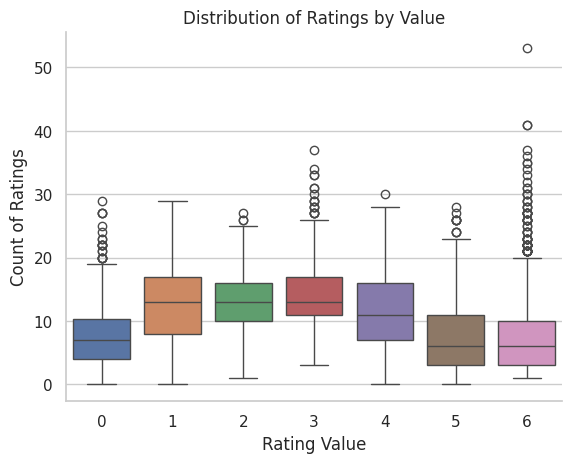

In [19]:
# Pull out a specific subset of columns
used_columns = ['0', '1', '2', '3', '4', '5', '6']
df = data.loc[:, used_columns]

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=df)

# Finalize the figure
ax.set_xlabel("Rating Value")
ax.set_ylabel("Count of Ratings")
ax.set_title("Distribution of Ratings by Value")
sns.despine()
fig.savefig("images/Ratings_distributions_box")

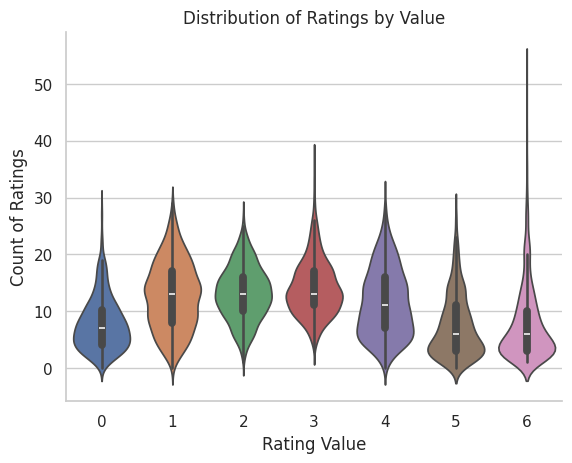

In [ ]:
# Pull out a specific subset of columns
used_columns = ['0', '1', '2', '3', '4', '5', '6']
df = data.loc[:, used_columns]

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=df)

# Finalize the figure
ax.set_xlabel("Rating Value")
ax.set_ylabel("Count of Ratings")
ax.set_title("Distribution of Ratings by Value")
sns.despine()
fig.savefig("images/Ratings_distributions_violin")

In [ ]:
# Pull out a specific subset of columns
used_columns = ['0', '1', '2', '3', '4', '5', '6']
df = data.loc[:, used_columns]

bins = range(0,55,)
binned = pd.cut()
binned

AttributeError: 'DataFrame' object has no attribute 'cut'

In [ ]:
# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=binned)

# Finalize the figure
ax.set_xlabel("Rating Value")
ax.set_ylabel("Count of Ratings")
ax.set_title("Distribution of Ratings by Value")
sns.despine()
fig.savefig("images/Ratings_distributions_box")

In [16]:

cutoff = 35
for rating in used_columns:
    col = data[rating]
    if not data[col > cutoff].empty:
        print('rating', rating, '\n', tabulate(data[col > cutoff]))
    else:
        print(f'No values > {cutoff} in rating {rating}')

No values > 35 in rating 0
No values > 35 in rating 1
No values > 35 in rating 2
rating 3 
 ---  -  --  -----------  --------------------------  -  -  -  --  --  --  -  -------  -------  --  -
174  H  72  Basic Latin  H (LATIN CAPITAL LETTER H)  3  1  6  37  13  12  9  3.58025  1.37717  81  B
---  -  --  -----------  --------------------------  -  -  -  --  --  --  -  -------  -------  --  -
No values > 35 in rating 4
No values > 35 in rating 5
rating 6 
 --  -  ----  -------------------  ---------------------------------------  -  -  -  --  --  --  --  -------  -------  ---  --
 1  ɤ   612  IPA Extensions       ɤ (LATIN SMALL LETTER RAMS HORN)         3  4  4   5  19  26  41  4.69608  1.55932  102  A
 2  ᴥ  7461  Phonetic Extensions  ᴥ (LATIN LETTER AIN)                     4  8  3   5  14  13  53  4.68     1.8306   100  A
 3  ö   246  Latin-1 Supplement   ö (LATIN SMALL LETTER O WITH DIAERESIS)  2  4  3   7  18  11  37  4.63415  1.62171   82  A
 4  Þ   222  Latin-1 Supplement   Þ (LA

In [17]:
table = []
for rating in used_columns:
    col = df[rating]
    skew_avgs = round(st.skew(col), 3)
    kurtosis_avgs = round(st.kurtosis(col), 3)
    table.append((rating, skew_avgs, kurtosis_avgs))
pd.DataFrame(table, columns=('rating','skew','kurtosis'))

KeyError: '0'

## Distribution of number of ratings is right skewed

Average is
Median is 